<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/CHR_and_Fuzzy_PID_controller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

пример кода для работы с ПИД регулятором

In [4]:
pip install control

https://robotics.stackexchange.com/questions/4901/how-to-tune-the-pid-parameters-using-fuzzy-logic

In [5]:
import control
import numpy as np

#передаточная функция: числитель и знаменатель
num = np.array([1])
den = np.array([3, 1, 1])
W = control.tf(num, den)
print('W(s) = ', W)

W(s) =  <TransferFunction>: sys[1]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


      1
-------------
3 s^2 + s + 1



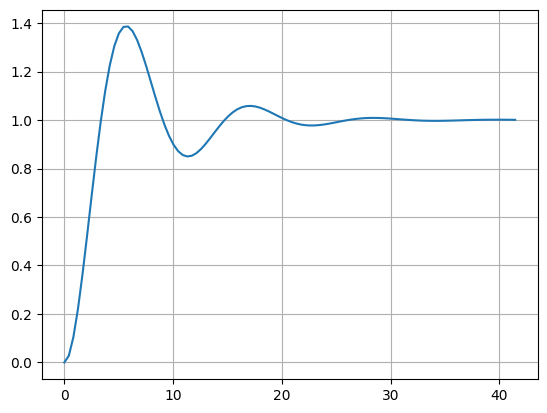

In [6]:
# реакция на ступенчатое воздействие

t, y = control.step_response(W)
import matplotlib.pyplot as plt
plt.plot(t,y)
plt.grid(True)


In [19]:
# начальные (инициация) настройки ПИД регулятора
Kp = 1
Ki = 1
Kd = 1
Wpid = Kp + Ki * control.tf(1, np.array([1, 0])) + Kd * control.tf(np.array([1, 0]), 1)

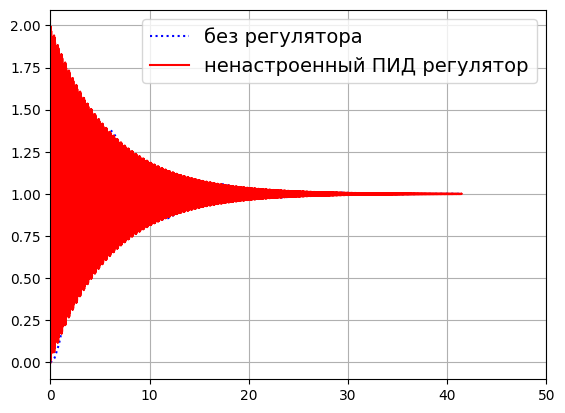

In [20]:
# проверяем реакцию системы с нестроенным ПИД-реглятором
Wopt = Wpid*W / (1 + Wpid*W)
tpid, ypid = control.step_response(Wopt)
plt.plot(t, y, ':b', label = 'без регулятора')
plt.plot(tpid, ypid, 'r', label = 'ненастроенный ПИД регулятор')
plt.xlim(0, 50)
plt.grid(True)
plt.legend(fontsize=14)

параметры настройки CHR = Chein - Hrones -Reswick

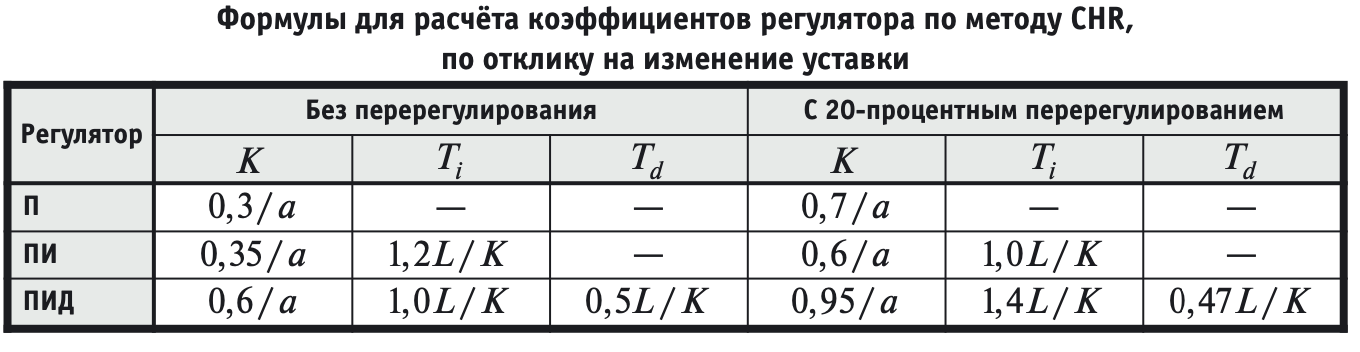

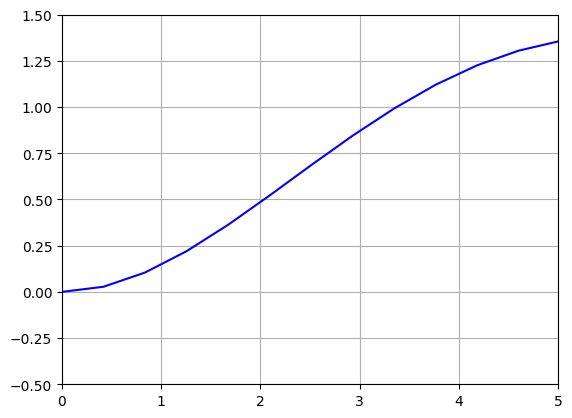

In [23]:
# определяем параметы а и L
plt.plot(t, y, 'b', label = 'без регулятора')
plt.xlim(0, 5)
plt.ylim(-0.5, 1.5)
plt.grid(True)

In [24]:
# настройка ПИД регулятора методом CHR (Chien, Hrones и Reswick)
a = 0.2
L = 0.7
Kp = 0.6 * a
Ki = (1.0 * L / Kp) ** -1
Kd = 0.5 * L / Kp
Wpid = Kp + Ki * control.tf(1,np.array([1, 0])) + Kd * control.tf(np.array([1, 0]), 1)

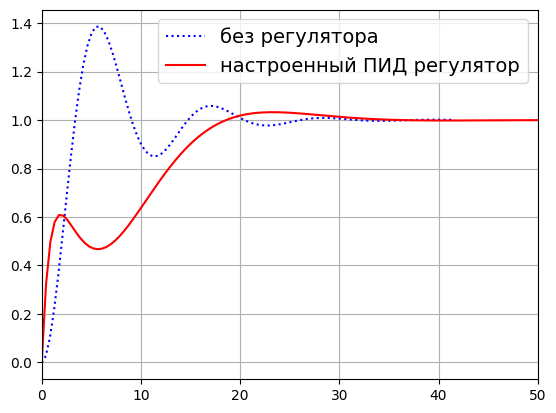

In [25]:
# проверяем реакцию системы с настроенным ПИД-реглятором
Wopt = Wpid*W / (1 + Wpid*W)
tpid, ypid = control.step_response(Wopt)
plt.plot(t, y, ':b', label = 'без регулятора')
plt.plot(tpid, ypid, 'r', label = 'настроенный ПИД регулятор')
plt.xlim(0, 50)
plt.grid(True)
plt.legend(fontsize=14)

In [26]:
pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=171e3c58b054978be7a296211ed46d17aa2b2246a0c56da9f483d0f8d42bd819
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [27]:
class pidcont():
    def __init__(self,P,I,D,pmax,pmin):
        self.kp=P
        self.kd=D
        self.ki=I
        self.pidmax=pmax
        self.pidmin=pmin
        self.desired=0.0
        self.error=0.0
        self.elast=0.0
        self.esum=0.0
        self.eder=0.0
    def update(self,current):
        self.error=self.desired-current
        self.eder=self.error-self.elast
        self.esum=self.esum+self.error
        self.elast=self.error

        if self.esum>self.pidmax:
            self.esum=self.pidmax
        elif self.esum<self.pidmin:
            self.esum=self.pidmin

        self.P = self.kp * self.error
        self.D = self.kd * self.eder
        self.I = self.ki * self.esum
        pid = self.P + self.I + self.D #общая ошибка выхода ПИД регулятора
        return pid
    def setDesired(self,d):
        self.desired = d
    def setGains(self,P,I,D):
        self.kp = P
        self.kd = D
        self.ki = I
    def setLimits(self,pmax,pmin):
        self.pidmax = pmax
        self.pidmin = pmin

In [28]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import numpy as np
from matplotlib import pyplot as plt

In [29]:
# определяем входные (анцендент) и выходные (консеквент) нечеткие переменные
ferr = ctrl.Antecedent(np.arange(-150, 150, 1), 'ferr')
fder = ctrl.Antecedent(np.arange(-150, 150, 1), 'fder')
fout = ctrl.Consequent(np.arange(-1, 1, 0.01), 'fout')

In [30]:
# создаем автоматически встроенной функцией юниверс и определяем логические переменные
# их 3, 5 или 7 может быть, если использовать встроенную функцию automf
# по умолчанию лингвистические переменные: poor, avarage, good
ferr.automf(3)
fder.automf(3)

In [31]:
# определяем лингвистические переменные выхода
fout['NB'] = fuzz.trimf(fout.universe, [-1, -1, -0.5]) #negetive big
fout['NS'] = fuzz.trimf(fout.universe, [-1, -0.5, 0])
fout['Z'] = fuzz.trimf(fout.universe, [-0.1, 0, 0.1])
fout['PS'] = fuzz.trimf(fout.universe, [0, 0.5, 2])
fout['PB'] = fuzz.trimf(fout.universe, [0.5, 1, 1]) #positive big

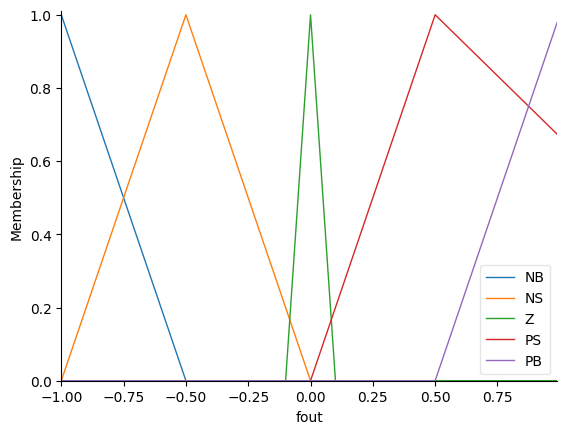

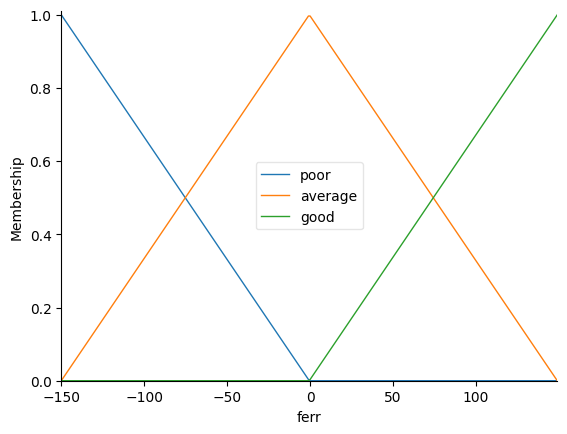

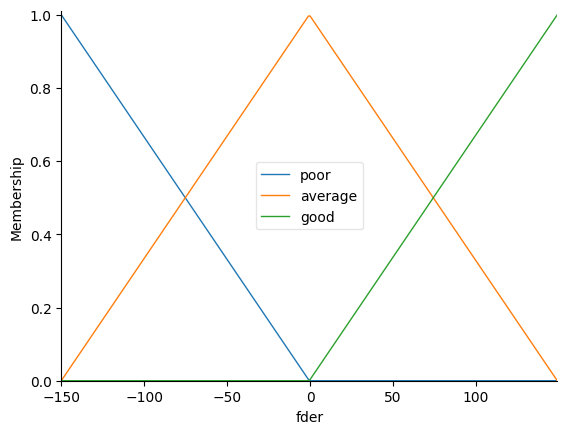

In [32]:
#готовим окно для вывода графиков
fout.view()
ferr.view()
fder.view()

In [33]:
# задаем базу правил для нечеткого вывода
rules=[]
rules.append(ctrl.Rule(ferr['poor'] & fder['poor'] , fout['NB']))
rules.append(ctrl.Rule(ferr['poor'] & fder['average'] , fout['NB']))
rules.append(ctrl.Rule(ferr['poor'] & fder['good'] , fout['NS']))
rules.append(ctrl.Rule(ferr['average'] & fder['poor'] , fout['NS']))
rules.append(ctrl.Rule(ferr['average'] & fder['average'] , fout['Z']))
rules.append(ctrl.Rule(ferr['average'] & fder['good'] , fout['PS']))
rules.append(ctrl.Rule(ferr['good'] & fder['poor'] , fout['PS']))
rules.append(ctrl.Rule(ferr['good'] & fder['average'] , fout['PB']))
rules.append(ctrl.Rule(ferr['good'] & fder['good'] , fout['PB']))

In [34]:
fctrl = ctrl.ControlSystem(rules) #определяем переменную специальную fctrl
fpid = ctrl.ControlSystemSimulation(fctrl) #нечеткий вывод и дефазицикация Мамдани

In [35]:
# инициируем класс ПИД регуляторов: П, И и Д
# входная (Кp,Ki,Kd,pmax,pmin):
erpid_fuz = pidcont(1.2,0.02,0.01,5,-5) #нечеткий ПИД
erpid_nonfuz = pidcont(1.2,0.02,0.01,5,-5) #четкий ПИД

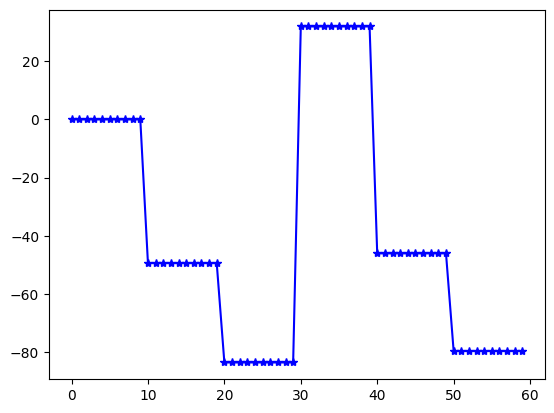

In [36]:
# задаем 5 участков (желаемое значение регулирования на входе)
d = np.zeros(10)
for i in range(5):
    d = np.append(d,np.ones(10)*np.random.uniform(-110,110,1))
plt.plot(d,'*-b')

In [37]:
# задаем начальные условия
y_fuz = []
y_fuz.append(0.0)
y_nonfuz = []
y_nonfuz.append(0.0)
e_fuz = []
de_fuz = []
e_nonfuz = []
de_nonfuz = []

kp = erpid_fuz.kp
kd = erpid_fuz.kd
ki = erpid_fuz.ki

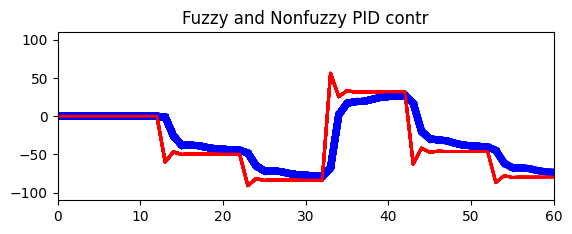

In [40]:
for i in range(len(d)):
    # формируем нечеткий ПИД регулятор
    erpid_fuz.setDesired(d[i]) # установили желаемое значение
    fpid.input['ferr'] = erpid_fuz.error # фазифицируем значение ошибки
    fpid.input['fder'] = erpid_fuz.eder # фазифицируем значение скорости ошибки
    fpid.compute() # генерируем выход нечеткого контроллера
    newpid = np.abs(fpid.output['fout']) # считаем нечеткий выход из контроллера
    erpid_fuz.setGains(newpid * kp, newpid * ki, newpid * kd) # выход умножаем на коэффициенты
    newy = erpid_fuz.update(y_fuz[-1]) # обновить оценку, аргумент - последний элемент массива
    newy = y_fuz[-1] + newy
    y_fuz.append(newy) # формируем массив рассогласований
    e_fuz.append(erpid_fuz.error) # формируем массив ошибок
    de_fuz.append(erpid_fuz.eder) # формируем массив прозводнных ошибок

    erpid_nonfuz.setDesired(d[i]) # четкий ПИД
    newynf = erpid_nonfuz.update(y_nonfuz[-1])
    newynf = y_nonfuz[-1] + newynf
    y_nonfuz.append(newynf)
    e_nonfuz.append(erpid_nonfuz.error)
    de_nonfuz.append(erpid_nonfuz.eder)

    ax1 = plt.subplot(2,1,1)
    ax1.set_xlim([0, len(d)])
    ax1.set_ylim([-110, 110])
    plt.grid()
    plt.plot(range(len(y_fuz)), y_fuz, 'b', linewidth=5.0)
    plt.plot(range(len(y_nonfuz)), y_nonfuz, 'r', linewidth=2.0)
    #plt.plot(range(len(d)),d,'g--')
    #plt.plot(range(len(e_nonfuz)),e_nonfuz,'r-')
    plt.title('Fuzzy and Nonfuzzy PID contr')

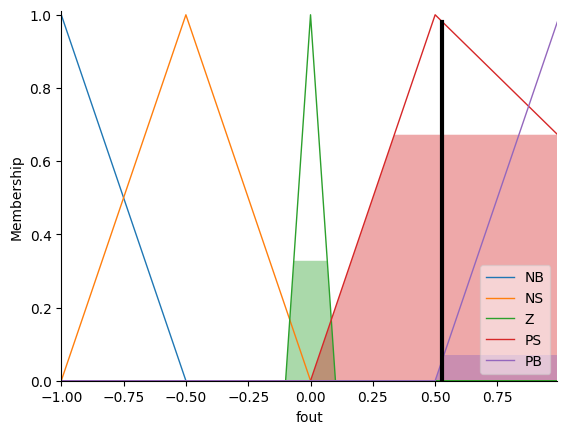

In [41]:
fpid.input['ferr'] = +10 # фазифицируем значение ошибки
fpid.input['fder'] = +100 # фазифицируем значение скорости ошибки
fpid.compute()
fout.view(sim = fpid)

# Анимированное изображение - пример

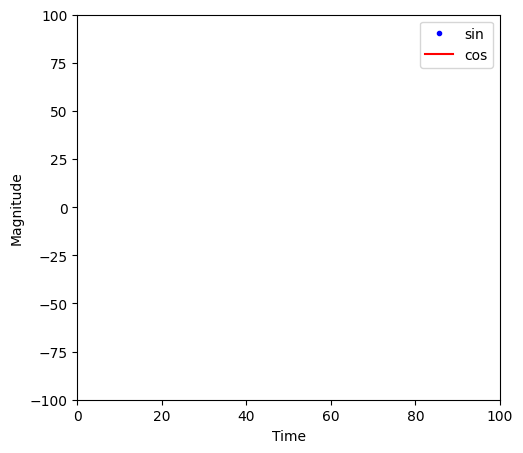

In [42]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# create a figure and axes
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)

# set up the subplots as needed
ax1.set_xlim(( 0, 100))
ax1.set_ylim((-100, 100))
ax1.set_xlabel('Time')
ax1.set_ylabel('Magnitude')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('')
line1, = ax1.plot([], [], '.b', lw=2)     # ax.plot returns a list of 2D line objects
line2, = ax1.plot([], [], '-r', ms=2)

ax1.legend(['sin','cos']);

In [43]:
# animation function. This is called sequentially
def drawframe(n):
    x = np.linspace(0, 100, len(d))
    #y = np.cos(2 * np.pi * (x - 0 * n))
    y = d
    line1.set_data(x, y)
    line2.set_data(x[:n], y[:n])
    #pt1.set_data(y1[0],y2[0])
    txt_title.set_text('Frame = {0:4d}'.format(n))
    return (line1, line2)

In [44]:
from matplotlib import animation

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=100, interval=100, blit=True)

In [46]:
from IPython.display import HTML
HTML(anim.to_html5_video())